In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy

rEarth = 6.378e6 #m
rMoon = 1.737e6 #m
dEM = 3.8e8 #m
mEarth = 5.9e24 #kg
mMoon = 7.3e22 #kg
G = scipy.constants.G  #m^3 kg^-1 s^-2

In [3]:
def potential(M, xm, ym, x, y,R):
    r = np.sqrt((x-xm)**2 + (y-ym)**2)
    return np.where(r<R, np.nan, -G*M/r)

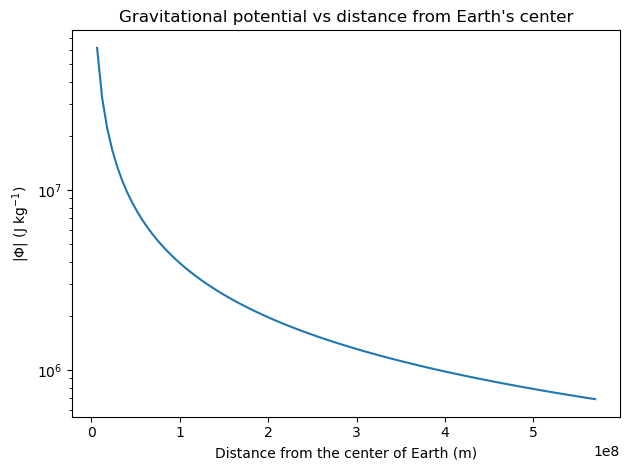

In [4]:
samples = 100
xs =np.linspace(rEarth, 1.5*dEM, samples)
ys = np.linspace(0,0,samples)
pots = potential(mEarth, 0,0,xs,ys,rEarth)
fig, ax = plt.subplots(1,1)
plt.plot(xs, np.abs(pots))
ax.set_xlabel("Distance from the center of Earth (m)")
ax.set_ylabel("|$\\Phi$| (J kg$^{-1}$)")
ax.set_yscale("log")
ax.set_title("Gravitational potential vs distance from Earth's center")
fig.tight_layout()

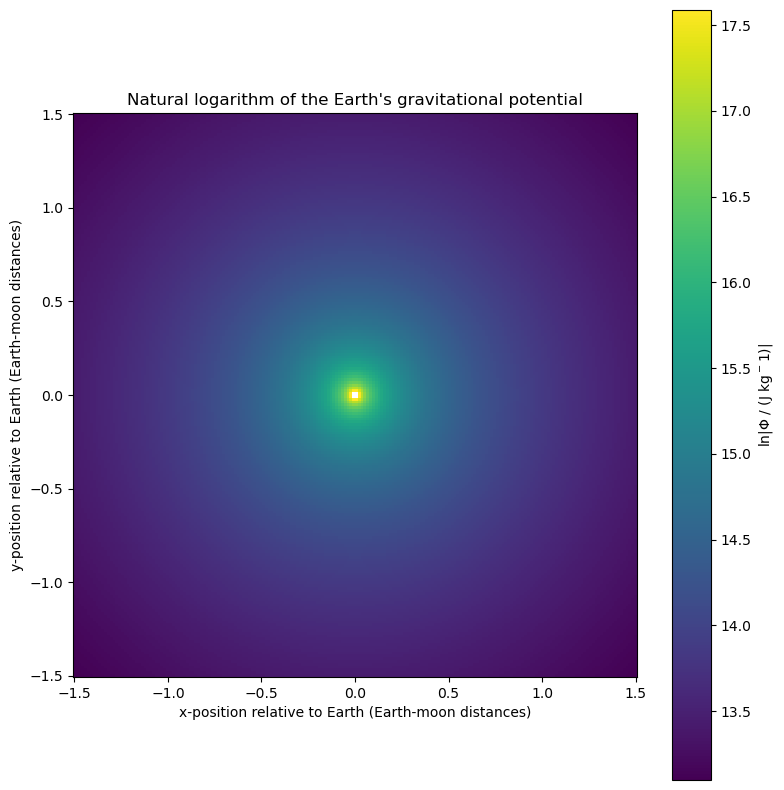

In [20]:
resolution = 200
xs, ys = np.meshgrid(np.linspace(-1.5*dEM, 1.5*dEM, resolution),np.linspace(-1.5*dEM, 1.5*dEM, resolution))
pot = potential(mEarth, 0,0,xs, ys,rEarth)

fig, ax = plt.subplots(1,1, figsize=(8,8))
img = ax.pcolormesh(xs/dEM, ys/dEM, np.log(np.abs(pot)))
fig.colorbar(img, label="ln|$\\Phi$ / (J kg$^-1$)|")
ax.set_xlabel("x-position relative to Earth (Earth-moon distances)")
ax.set_ylabel("y-position relative to Earth (Earth-moon distances)")
ax.set_title("Natural logarithm of the Earth's gravitational potential")
ax.set_aspect(1)
fig.tight_layout()


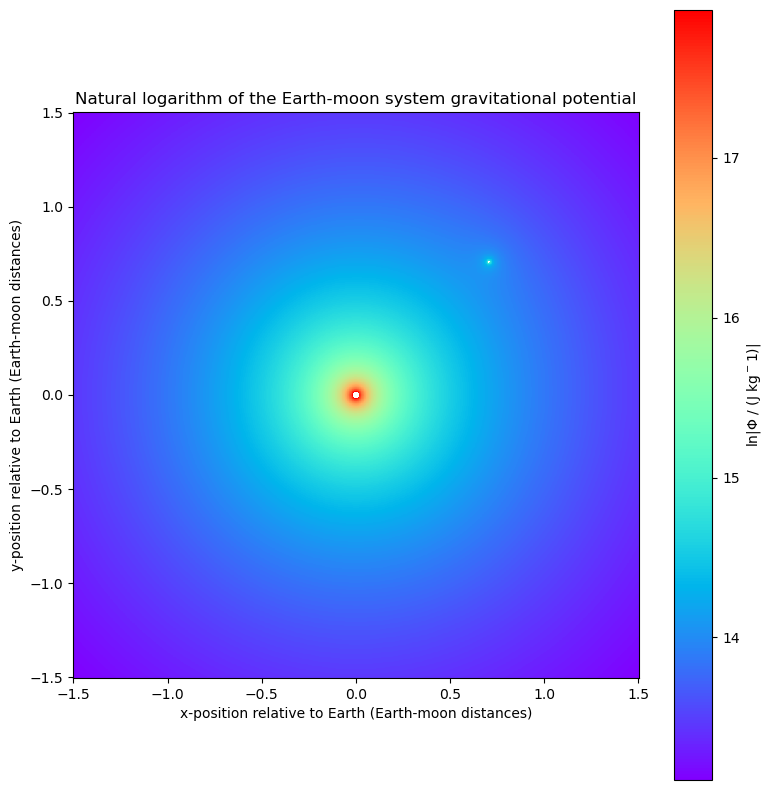

In [63]:
resolution = 800
xs, ys = np.meshgrid(np.linspace(-1.5*dEM, 1.5*dEM, resolution),np.linspace(-1.5*dEM, 1.5*dEM, resolution))
pot = potential(mEarth, 0,0,xs, ys,rEarth) + potential(mMoon, dEM/np.sqrt(2), dEM/np.sqrt(2), xs, ys, rMoon)

fig, ax = plt.subplots(1,1, figsize=(8,8))
img = ax.pcolormesh(xs/dEM, ys/dEM, np.log(np.abs(pot)),cmap = cm.rainbow)
fig.colorbar(img, label="ln|$\\Phi$ / (J kg$^-1$)|")
ax.set_xlabel("x-position relative to Earth (Earth-moon distances)")
ax.set_ylabel("y-position relative to Earth (Earth-moon distances)")
ax.set_title("Natural logarithm of the Earth-moon system gravitational potential")
ax.set_aspect(1)
fig.tight_layout()

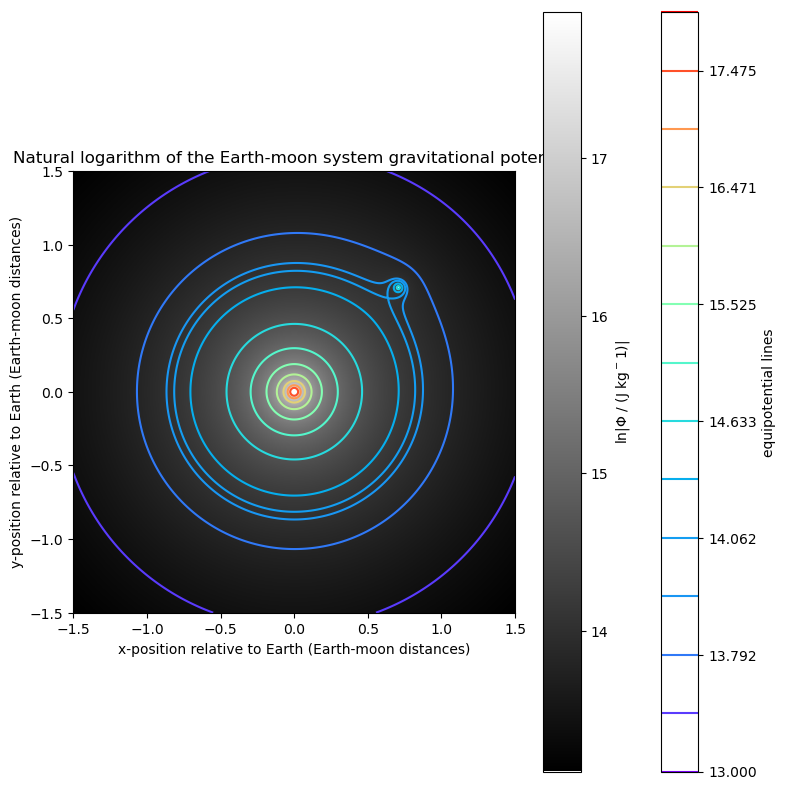

In [98]:
levels = np.sort(np.append(np.logspace(np.log(13), np.log(18), 12, base=np.e), (14,14.062)))

fig, ax = plt.subplots(1,1, figsize=(8,8))
lines= ax.contour(xs/dEM, ys/dEM, np.log(np.abs(pot)), cmap="rainbow", levels=levels)
img = ax.pcolormesh(xs/dEM, ys/dEM, np.log(np.abs(pot)),cmap = cm.grey)
fig.colorbar(lines, label="equipotential lines")
fig.colorbar(img, label="ln|$\\Phi$ / (J kg$^-1$)|")
ax.set_xlabel("x-position relative to Earth (Earth-moon distances)")
ax.set_ylabel("y-position relative to Earth (Earth-moon distances)")
ax.set_title("Natural logarithm of the Earth-moon system gravitational potential")
ax.set_aspect(1)
fig.tight_layout()